In [159]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
from scipy.stats import ttest_ind

demos = ['women', 'black', 'hispanic', 'native american']
%matplotlib inline
# hard coded it because of assignment errors

In [96]:
def startup():
    all_unis = {}
    all_completions = {}
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    for year in range(2008, 2022):
        all_unis[year] = unis
        all_completions[year] = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
    demo_names = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, demo_names

In [97]:
def make_years(completions, unis, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = unis[year], completions[year]
        years[year] = [year_completions, year_unis]
    return years

In [142]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        unis, data = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    #print(csMerge)
    return csMerge, nonCsMerge

In [118]:
def make_percents(cs, nonCs):
    cs = cs.set_index('UNITID')
    nonCs = nonCs.set_index('UNITID')
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [100]:
def cs_nonCs_difference(cs, nonCs):
    cs = cs.set_index('UNITID')
    nonCs = nonCs.set_index('UNITID')
    difference = cs - nonCs
    difference.columns = ['d_%s' % col for col in difference.columns]
    difference = difference.reset_index()
    return difference

In [127]:
def get_avg(data):
    data = data.groupby('UNITID').mean()
    return data.reset_index()

In [102]:
def make_correlation_df(data, unis, demo):
    correlation_df_merge = pd.merge(data[['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], unis)
    non_differences = correlation_df_merge.drop(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT'], axis=1)
    correlations_df = non_differences.corrwith(correlation_df_merge[demo])
    return correlations_df.dropna()
    


In [105]:
def binarize(data, unis, col):
    series = unis[col]
    unique_vals = set(series.unique())
    #binarized_unis = pd.DataFrame()
    for value in unique_vals:
        data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)

In [146]:
def demo_df(all_unis):
    binarized_unis = pd.DataFrame()
    #binarized_unis['UNITID'] = all_unis[2021]['UNITID']
    all_unis[2021] = all_unis[2021].set_index('UNITID')
    cols = ['SECTOR', 'INSTSIZE', 'UGOFFER', 'GROFFER', 'HBCU', 'HDEGOFR1', 'MEDICAL', 'LOCALE', 'C21BASIC', 'CBSATYPE', 'C21SZSET']
    for col in cols:
        binarize(binarized_unis, all_unis[2021], col)
    return binarized_unis


In [145]:
all_unis[2021]['SECTOR'] == 1

0        True
1        True
2       False
3        True
4        True
        ...  
6284    False
6285    False
6286    False
6287    False
6288    False
Name: SECTOR, Length: 6289, dtype: bool

In [130]:
def difference_df(difference, df):
    final_df = pd.merge(difference, df, on='UNITID')

In [147]:
all_unis, all_completions, demo_names = startup()
years = make_years(all_completions, all_unis, 2008, 2021)
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
difference = cs_nonCs_difference(cs_percent, nonCs_percent)
average = get_avg(difference)
binarized_unis = demo_df(all_unis)
binarized_df = difference_df(average, binarized_unis)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [148]:
binarized_unis

,SECTOR_0,SECTOR_1,SECTOR_2,SECTOR_3,SECTOR_4,SECTOR_5,SECTOR_6,SECTOR_7,SECTOR_8,SECTOR_9,...,C21SZSET_10,C21SZSET_11,C21SZSET_12,C21SZSET_13,C21SZSET_14,C21SZSET_15,C21SZSET_16,C21SZSET_17,C21SZSET_18,C21SZSET_-2
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
100663,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
100690,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100706,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
100724,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497301,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
497310,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
497329,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [150]:
average = average.set_index('UNITID')

In [156]:
len(set(average.index).intersection(set(binarized_unis.index)))

3024

In [151]:
merged = pd.merge(average, binarized_unis, left_index=True, right_index=True)

In [158]:
merged = merged.dropna()

In [160]:
merged

,d_CTOTALW,d_CAIANT,d_CBKAAT,d_CHISPT,d_CTOTALT,SECTOR_0,SECTOR_1,SECTOR_2,SECTOR_3,SECTOR_4,...,C21SZSET_10,C21SZSET_11,C21SZSET_12,C21SZSET_13,C21SZSET_14,C21SZSET_15,C21SZSET_16,C21SZSET_17,C21SZSET_18,C21SZSET_-2
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,-0.218325,-0.001517,-0.005820,0.003230,0.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
100663,-0.434725,-0.002092,-0.082411,-0.006501,0.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
100690,-0.106788,0.000000,-0.109446,-0.019807,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100706,-0.249201,-0.006209,-0.048827,-0.009303,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
100724,-0.277982,-0.001078,0.029205,-0.007412,0.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495013,-0.124214,0.000000,0.000000,0.004717,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
495767,-0.237446,0.000687,-0.005728,-0.007395,0.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
496186,0.055723,0.000000,0.079731,0.038622,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
results = []
for col in binarized_unis.columns.unique():
    pos = merged.loc[merged[col] == 1, 'd_CHISPT']
    neg = merged.loc[merged[col] == 0, 'd_CHISPT']
    min_length = min(len(pos), len(neg))
    if min_length < 250:
        continue
    stat, pval = ttest_ind(pos, neg, equal_var=False, alternative='two-sided')
    results.append([col, pval])
    

In [220]:
results = pd.DataFrame(results)

In [221]:
results.columns = ['col', 'pval']
results = results.dropna()
results.sort_values('pval')


,col,pval
1,SECTOR_2,1.110947e-07
20,CBSATYPE_1,2.713326e-07
6,INSTSIZE_4,3.427382e-07
4,INSTSIZE_2,1.155403e-06
24,C21SZSET_11,7.016699e-06
11,HDEGOFR1_20,1.397359e-04
21,CBSATYPE_2,3.631387e-04
13,LOCALE_32,4.989323e-04
9,HDEGOFR1_40,8.636846e-04
16,LOCALE_11,1.289331e-03


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/3783826305.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


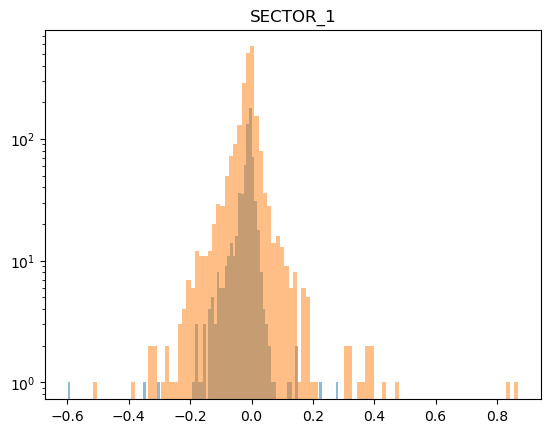

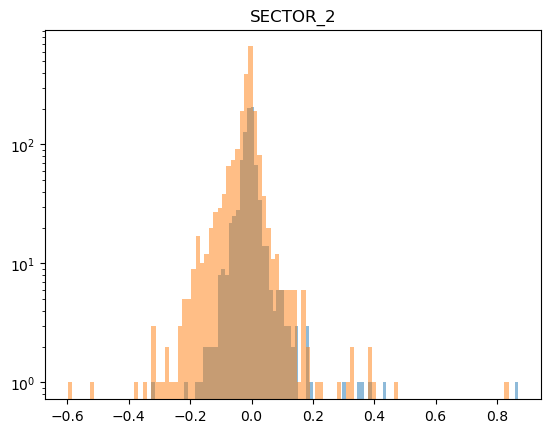

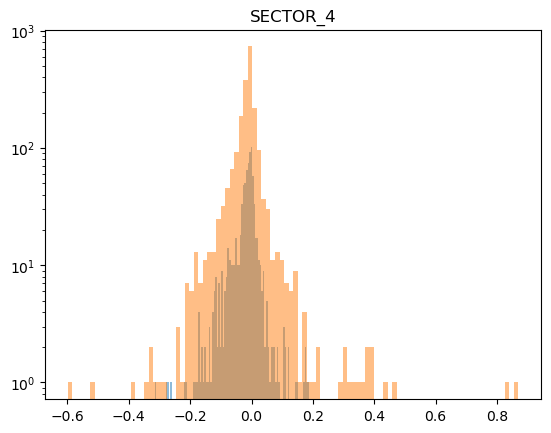

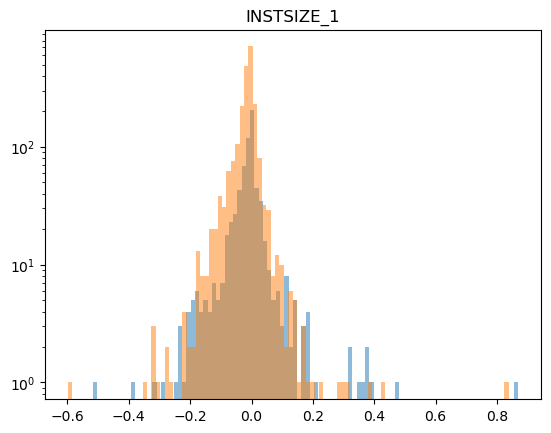

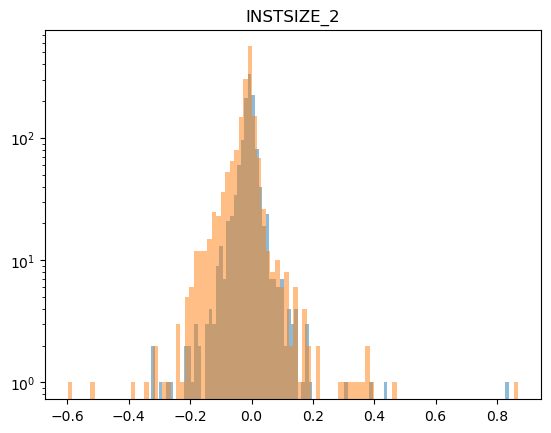

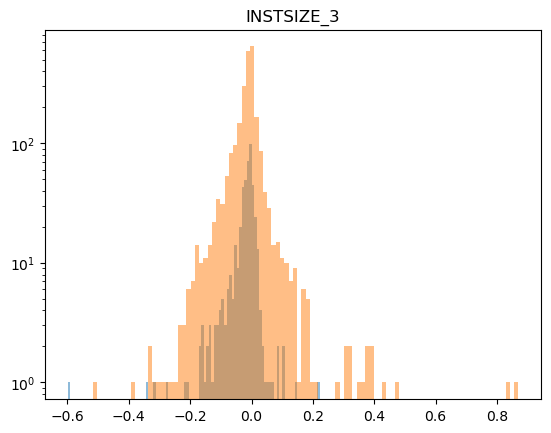

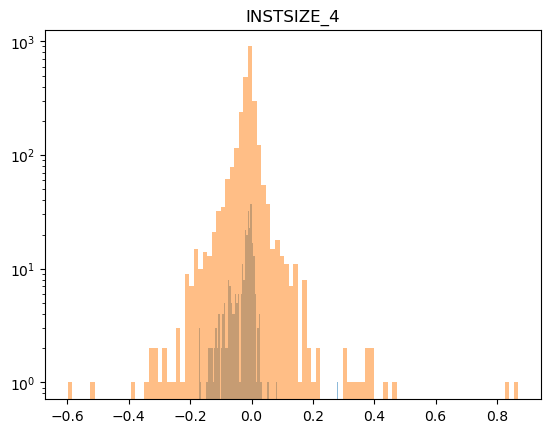

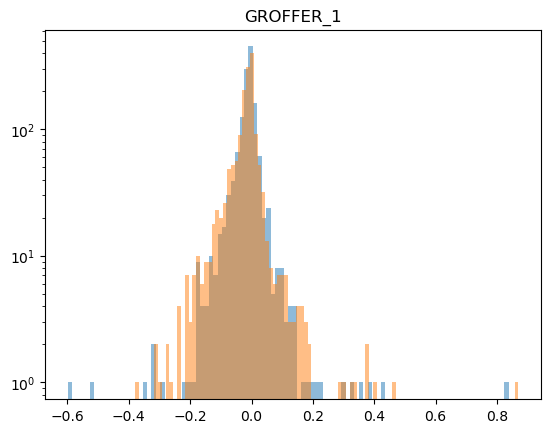

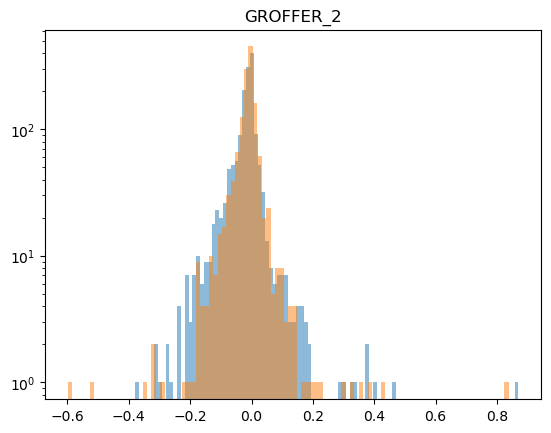

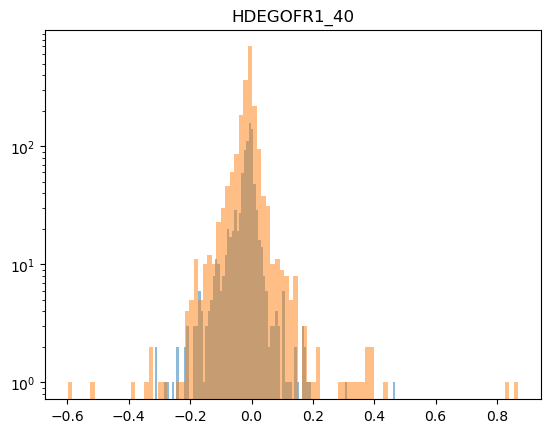

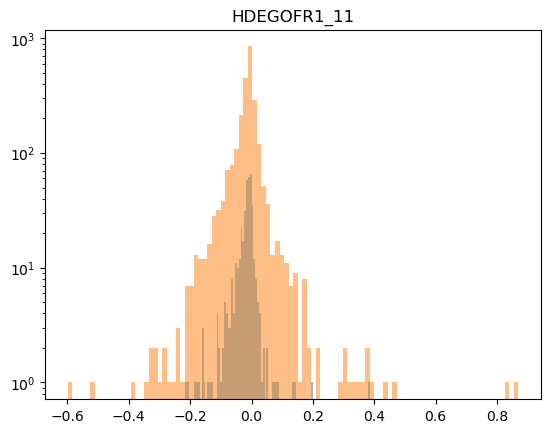

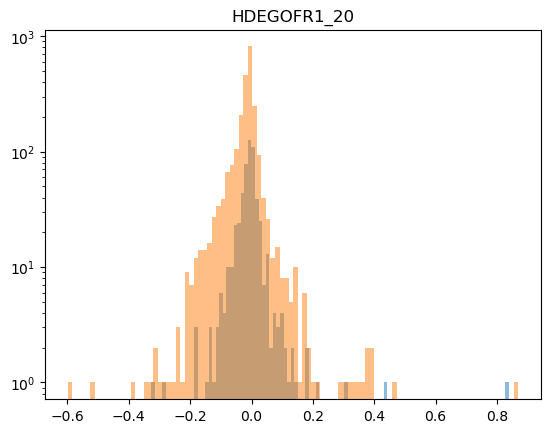

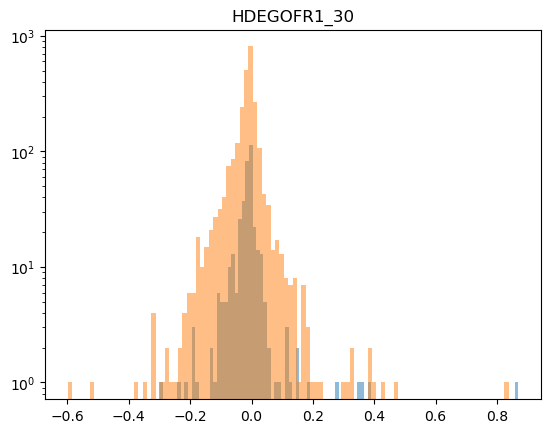

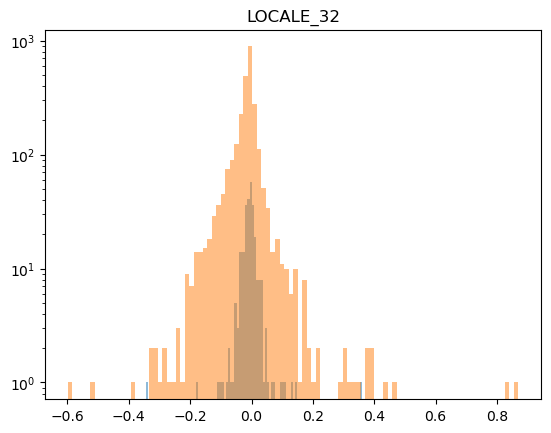

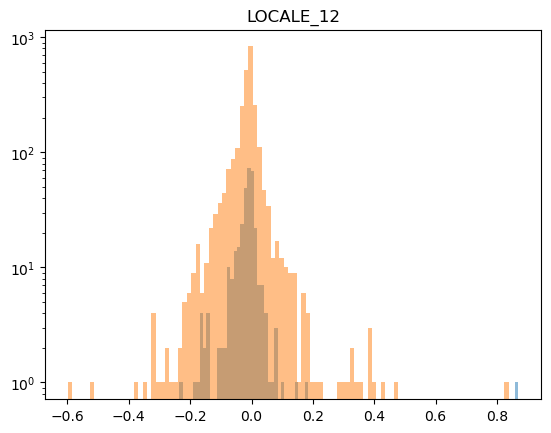

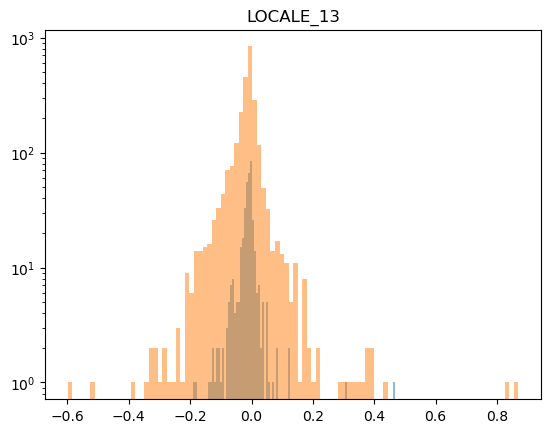

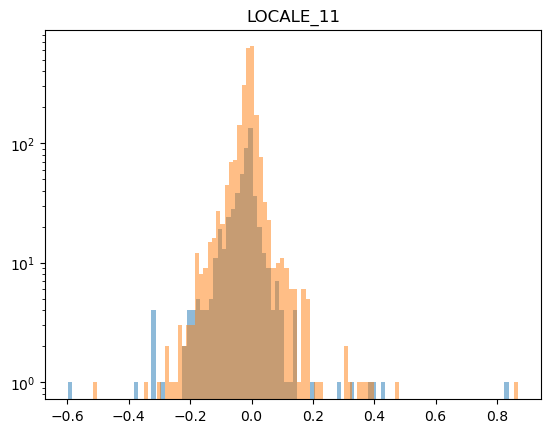

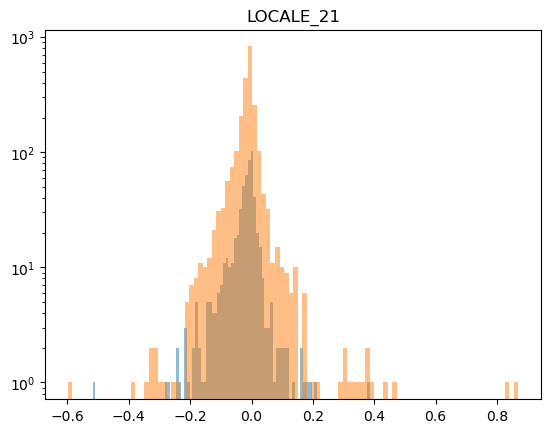

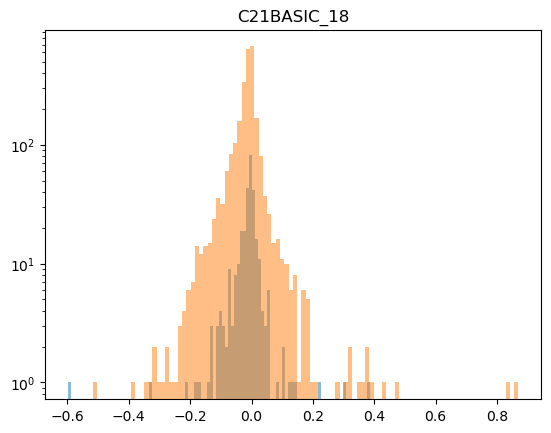

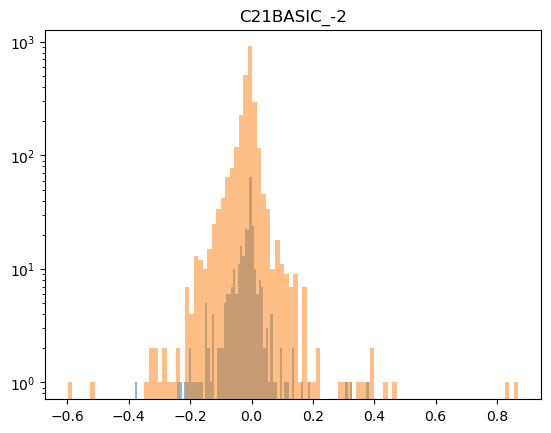

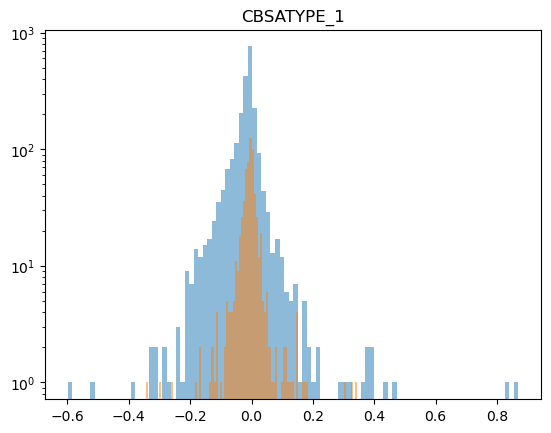

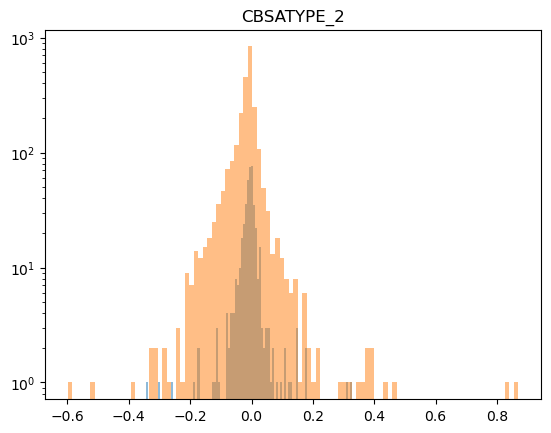

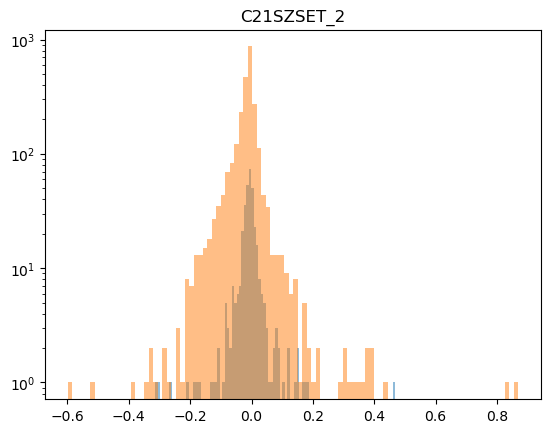

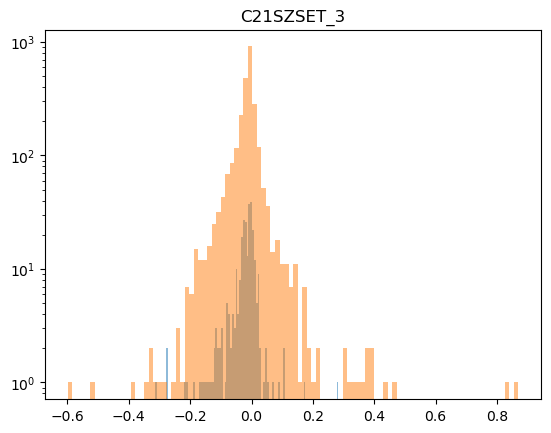

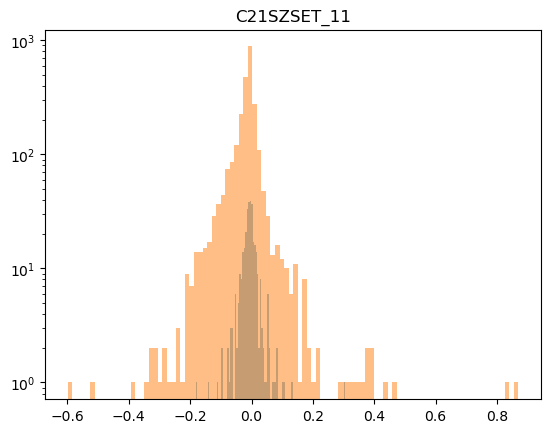

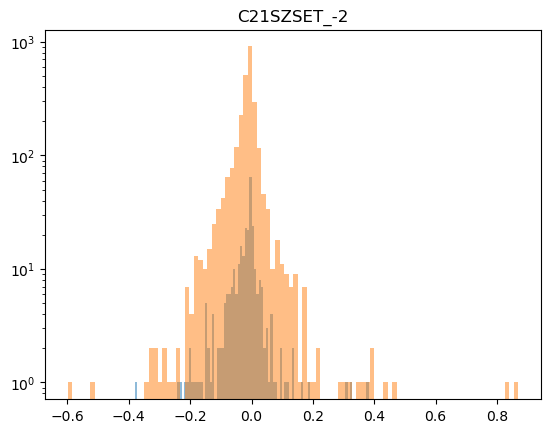

<Figure size 640x480 with 0 Axes>

In [222]:
for col in results['col'].values:
    pos = merged.loc[merged[col] == 1, 'd_CHISPT']
    neg = merged.loc[merged[col] == 0, 'd_CHISPT']
    plt.hist(pos, alpha = 0.5, bins=100)
    #plt.figure()
    plt.hist(neg, alpha = 0.5, bins=100)
    plt.yscale('log')
    plt.title(col)
    plt.figure()

In [197]:
len(pos), len(neg)

(694, 2263)

In [184]:
pos.mean(), neg.mean()

(-0.010074048489363323, -0.04783515053226856)